In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import sys
from normalize_data import getNormalizedDataset

df = getNormalizedDataset()

(230396, 18)
(230060, 18)
(230041, 18)
(220417, 19)


In [66]:
sns.set(style='ticks', context='talk')
df['mes'] = df['fecha'].dt.month
df['año'] = df['fecha'].dt.year

# Analisis introductorio
# ------------------------------------------------------------------------------------------------------------

In [135]:
# Es interesante tambien ver matrices de correlacion por tipo de propiedad.
corr = df.corr()
corr.drop(columns=['mes','año','precio_dolar','extras'],inplace=True)

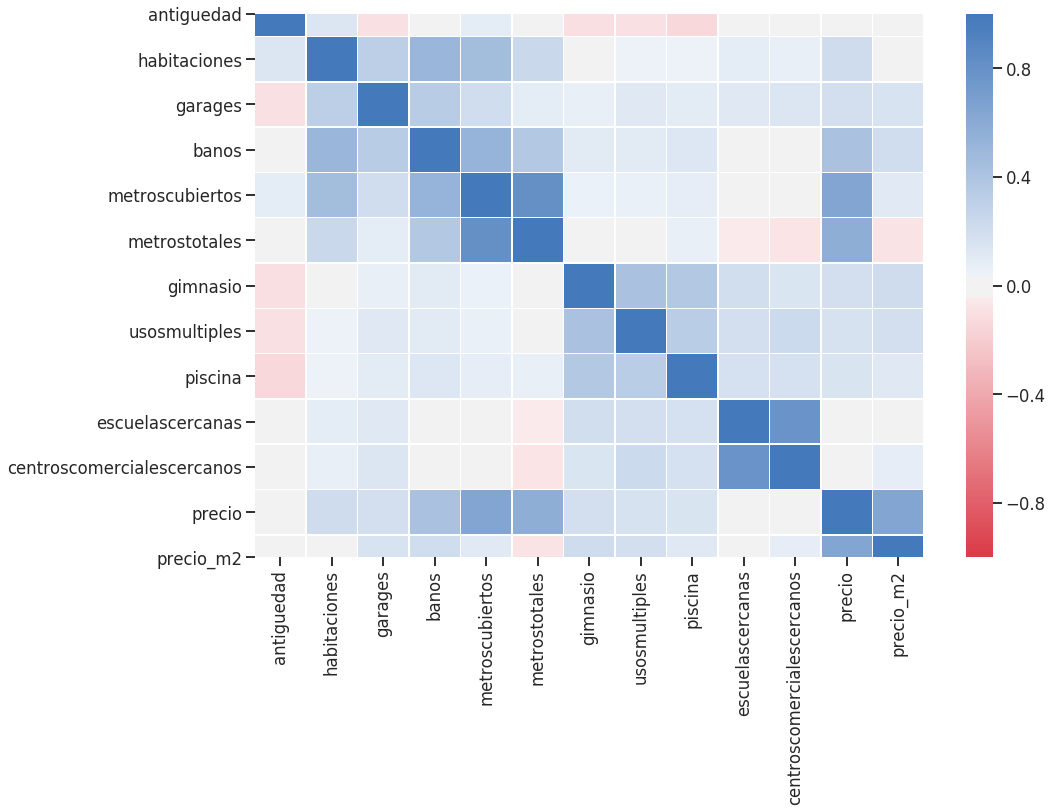

In [137]:
plt.figure(figsize=(15, 10))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap=cmap,
            #annot=True,
            linewidth=0.5,
           vmin=-1,
           vmax=1)


# De este grafico se observa:
# Las correlaciones negativas no son muchas. Principalmente en la antiguedad.
# A menor antiguedad pareceria que hay menor cantidad de extras.
# El precio se ve influenciado principalmente por los metros cubiertos y totales y por la cantidad de baños y habitaciones.
# El resto, no parecen ser lo suficientemente fuerte como para llamar la atencion.

Text(0.5, 1, 'Apartamentos \n')

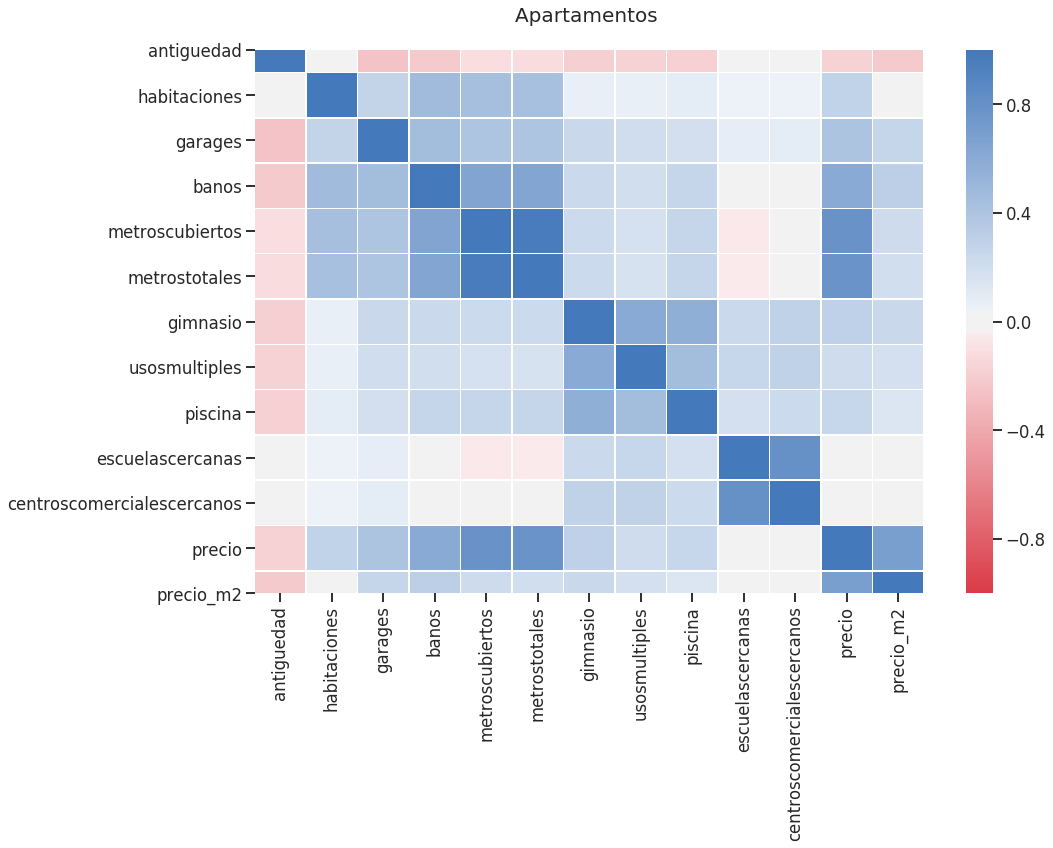

In [69]:
# Y si miro las correlaciones para grupos particulares? Por ejemplo tipos de propiedad?
df2 = df.copy()
df2.drop(columns=['precio_dolar','extras','mes','año'], inplace=True)
corr = df2[df2['tipodepropiedad']=='Apartamento'].corr()
plt.figure(figsize=(15, 10))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
ax = sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap=cmap,
            #annot=True,
            linewidth=0.5,
           vmin=-1,
           vmax=1)

ax.set_title('Apartamentos \n', fontdict={'fontsize':20})

# En los apartamentos, se ve que la correlacion entre la antiguedad y la mayoria de campos (entre ellos el precio) es negativa
# Esto significa que si aumenta la antiguedad, disminuye el precio y los otros campos.

Text(0.5, 0, '\n Precio m2 ')

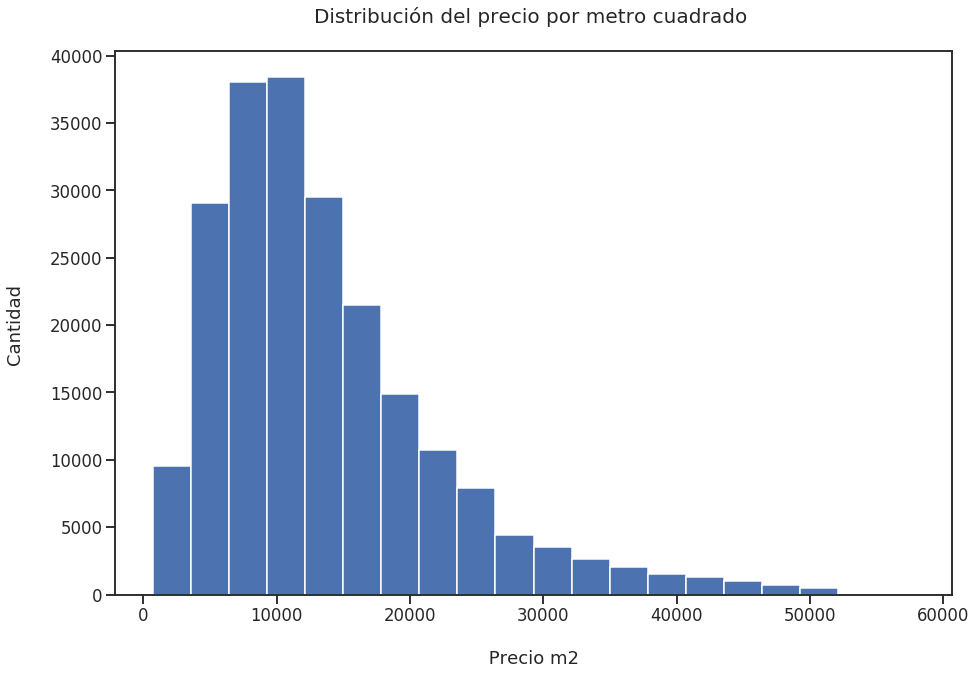

In [134]:
plt.figure(figsize=(15,10))
ax = plt.hist(df.precio_m2, bins=20)
plt.title('Distribución del precio por metro cuadrado \n', fontdict={'fontsize':20})
plt.ylabel('Cantidad \n', fontsize=18)
plt.xlabel('\n Precio m2 ', fontsize=18)

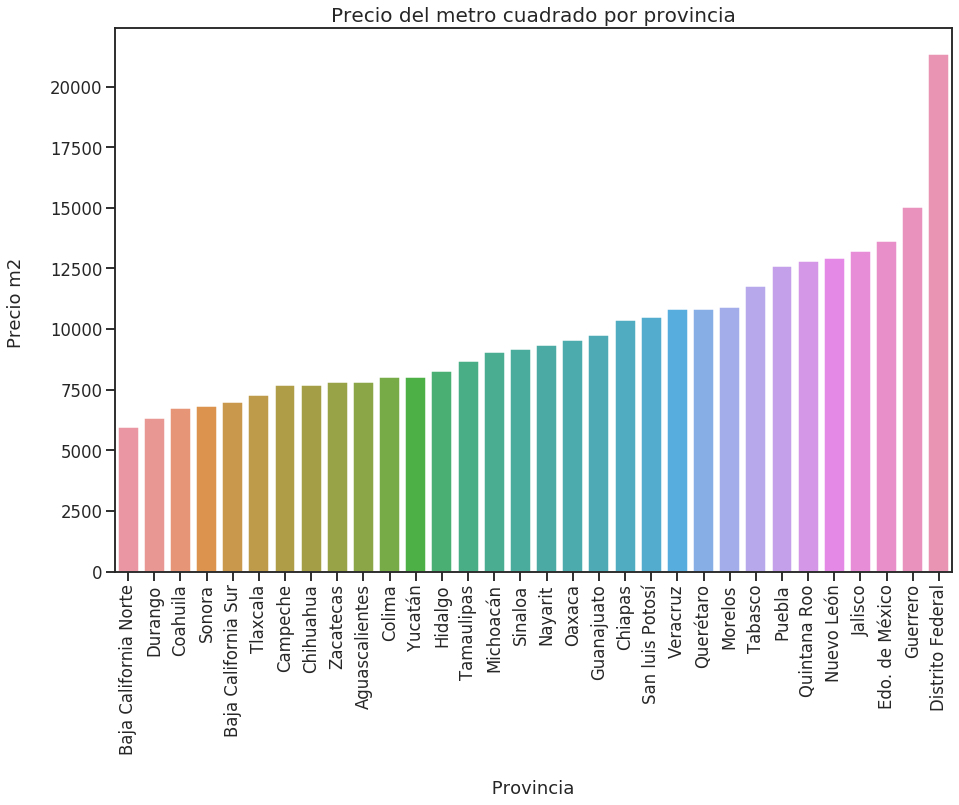

In [71]:
plt.figure(figsize=(15,10))

df2 = df.copy()
df_provs = df2.groupby('provincia').precio_m2.mean().reset_index()
df_provs.sort_values(by='precio_m2', inplace=True)
df_provs = df_provs.reset_index(drop=True)
df_provs['provincia'] = df_provs['provincia'].astype(str)

ax = sns.barplot(data=df_provs, x='provincia', y='precio_m2')
ax.set_title('Precio del metro cuadrado por provincia', fontdict={'fontsize':20})
ax.set_ylabel('Precio m2 \n', fontsize=18)
ax.set_xlabel('\n Provincia ', fontsize=18)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Analisis de los tipos de propiedad
# ------------------------------------------------------------------------------------------------------------

In [72]:
df3 = df.groupby('tipodepropiedad').agg(promedio_m2=('precio_m2','mean'), tamano=('tipodepropiedad', 'size')).reset_index()
df3.sort_values(by='tamano', ascending=False)
df3[df3['tamano'] < 1000].sort_values(by='tamano')

,tipodepropiedad,promedio_m2,tamano
22,Hospedaje,10416.67,1
23,Garage,12500.00,1
12,Lote,2383.21,4
8,Huerta,16305.73,17
20,Terreno industrial,27296.35,21
13,Nave industrial,10845.24,56
15,Otros,20387.42,88
5,Departamento Compartido,17705.74,135
11,Local en centro comercial,24613.43,147
17,Rancho,17179.69,152


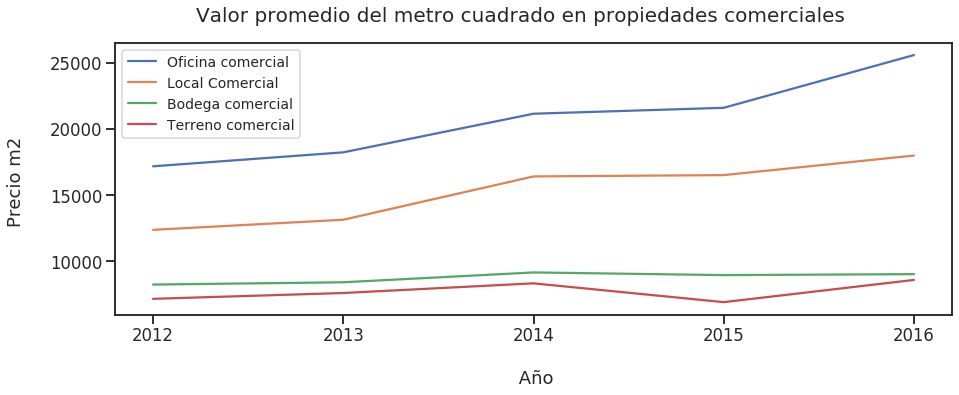

In [73]:
# Me quedo solo con los comerciales y grafico el promedio del m2 en el tiempo para cada uno.
comerciales = df3[(df3['tamano'] < 3000) & (df3['tamano'] > 1000)].sort_values(by="promedio_m2", ascending=False).tipodepropiedad.unique().to_list()
comerciales
dfcomerciales = df[df['tipodepropiedad'].isin(comerciales)]

fig, ax1 = plt.subplots(1,1, figsize=(15,5))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Valor promedio del metro cuadrado en propiedades comerciales',fontsize=20)

dfcomerciales = dfcomerciales.groupby(['año', 'tipodepropiedad']).agg(precio_m2=('precio_m2', 'mean')).reset_index()

for i in comerciales: 
    dfplot = dfcomerciales[dfcomerciales['tipodepropiedad'] == i]
    ax1.plot(dfplot.año,\
            dfplot.precio_m2,\
            label=i)

plt.xticks([2012,2013,2014,2015,2016])    
ax1.set_xlabel("\n Año", fontsize=18)
ax1.set_ylabel("Precio m2 \n", fontsize=18)
ax1.legend(loc='best', title_fontsize=16, fontsize=14)

In [74]:
# Resulta interesante entonces que el comportamiento de la Oficina comercial y el del local comercial son similares.
# Mientras que el de el terreno comercial y la bodega comercial tambien son similares.

# Entonces se toma la decision de agrupar oficina comercial y local comercial, bodega comercial y terreno comercial.
# Se remueven todas las otras propiedades.

df.loc[df['tipodepropiedad'] == 'Oficina comercial', ['tipodepropiedad']] = 'Local Comercial'
df.loc[df['tipodepropiedad'] == 'Bodega comercial', ['tipodepropiedad']] = 'Terreno comercial'
df3 = df.groupby('tipodepropiedad').agg(promedio_m2=('precio_m2','mean'), tamano=('tipodepropiedad', 'size')).reset_index()
propiedades_validas = df3[df3['tamano'] > 1000].tipodepropiedad.unique().to_list()

df = df[df['tipodepropiedad'].isin(propiedades_validas)]
df['tipodepropiedad'].cat.remove_unused_categories(inplace=True)
df['tipodepropiedad'].unique()

[Apartamento, Casa en condominio, Casa, Terreno, Local Comercial, Terreno comercial]
Categories (6, object): [Apartamento, Casa en condominio, Casa, Terreno, Local Comercial, Terreno comercial]

Text(0.5, 0, '\n Tipo de propiedad ')

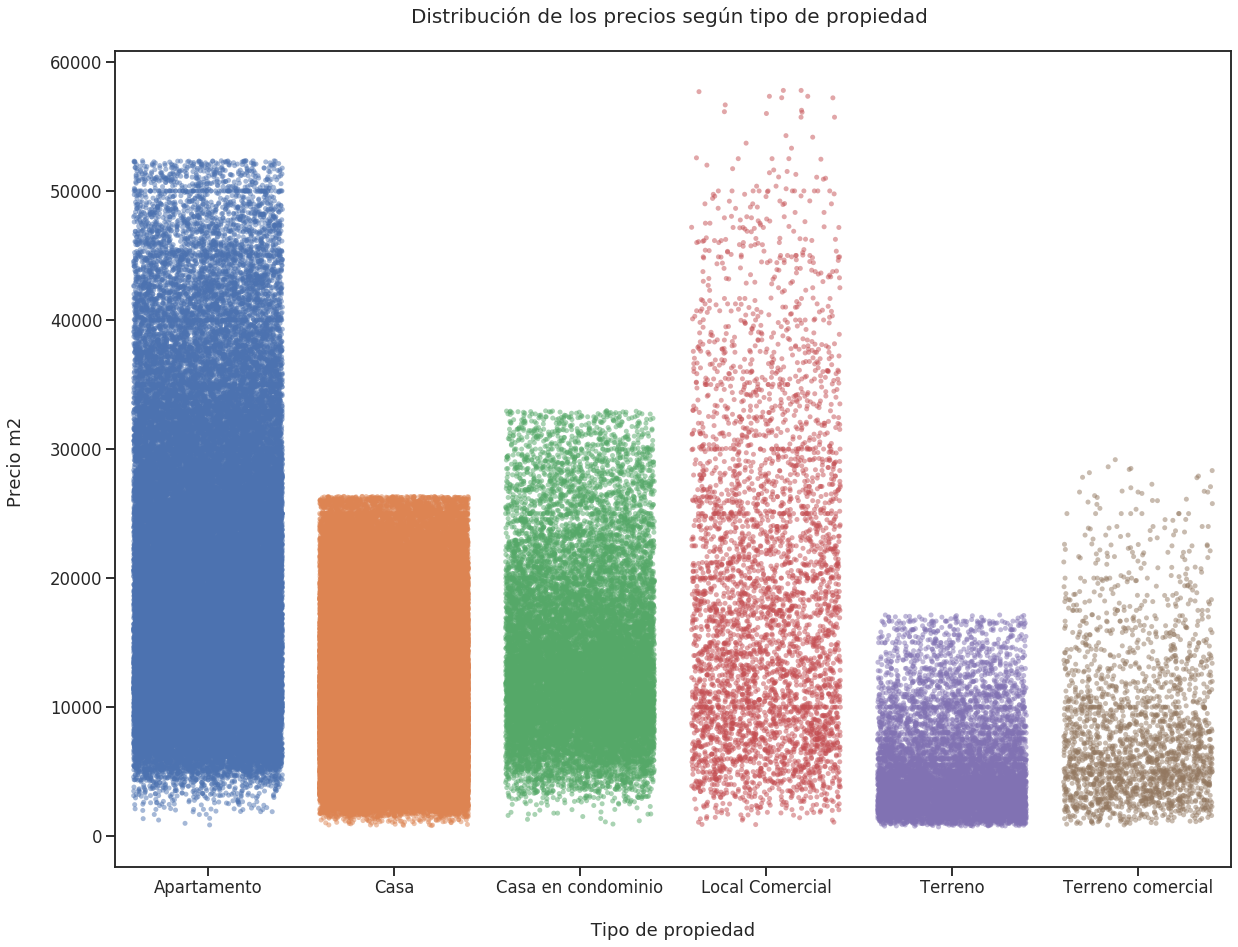

In [126]:
plt.figure(figsize=(20,15))
ax = sns.stripplot(x="tipodepropiedad", y="precio_m2", data=df, jitter=0.4, alpha=0.5)
ax.set_title('Distribución de los precios según tipo de propiedad \n', fontdict={'fontsize':20})
ax.set_ylabel('Precio m2 \n', fontsize=18)
ax.set_xlabel('\n Tipo de propiedad ', fontsize=18)

# Analisis por antiguedad:
# ------------------------------------------------------------------------------------------------------------

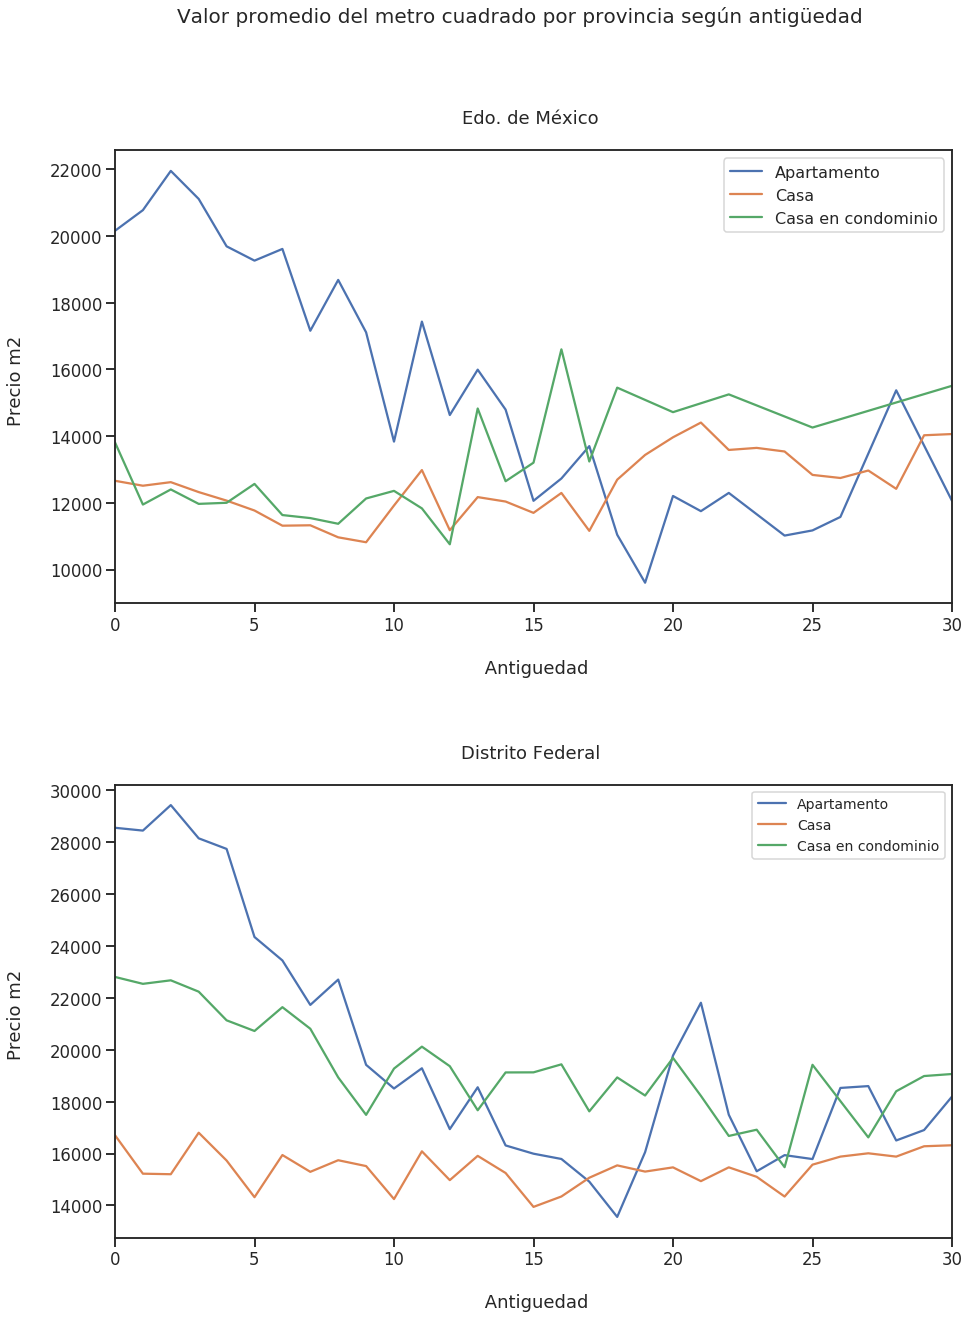

In [76]:
# Influye la antiguedad en el valor de las casas?
# Tomo datos agrupando por antiguedad, tipo de propiedad y provincia. 
# Filtro aquellos grupos donde la cantidad no es suficiente como para hacer un analisis consistente
# Armo un grafico para cada provincia, comparando los tipos de propiedad

df2 = df.copy()
df2 = df2.groupby(['antiguedad','tipodepropiedad','provincia']).filter(lambda x: len(x)>10).groupby(['antiguedad','tipodepropiedad','provincia']).agg({'precio_m2':'mean'})
df2 = df2.reset_index()
df2.dropna(subset=['precio_m2'], inplace=True)
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(15,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Valor promedio del metro cuadrado por provincia según antigüedad',fontsize=20)

for name in ['Apartamento','Casa', 'Casa en condominio']:
    ax1.plot(df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Edo. de México')].antiguedad,\
            df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Edo. de México')].precio_m2,\
            label=name)
    ax1.set_title('Edo. de México \n')
    ax2.plot(df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Distrito Federal')].antiguedad,\
            df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Distrito Federal')].precio_m2,\
            label=name)
    ax2.set_title('Distrito Federal \n')
    ax1.set_xlim([0,30])
    ax2.set_xlim([0,30])

ax1.set_xlabel("\n Antiguedad", fontsize=18)
ax1.set_ylabel("Precio m2 \n", fontsize=18)
ax1.legend(loc='best', fontsize=16)
ax2.set_xlabel("\n Antiguedad", fontsize=18)
ax2.set_ylabel("Precio m2 \n", fontsize=18)
ax2.legend(loc='best', fontsize=14)

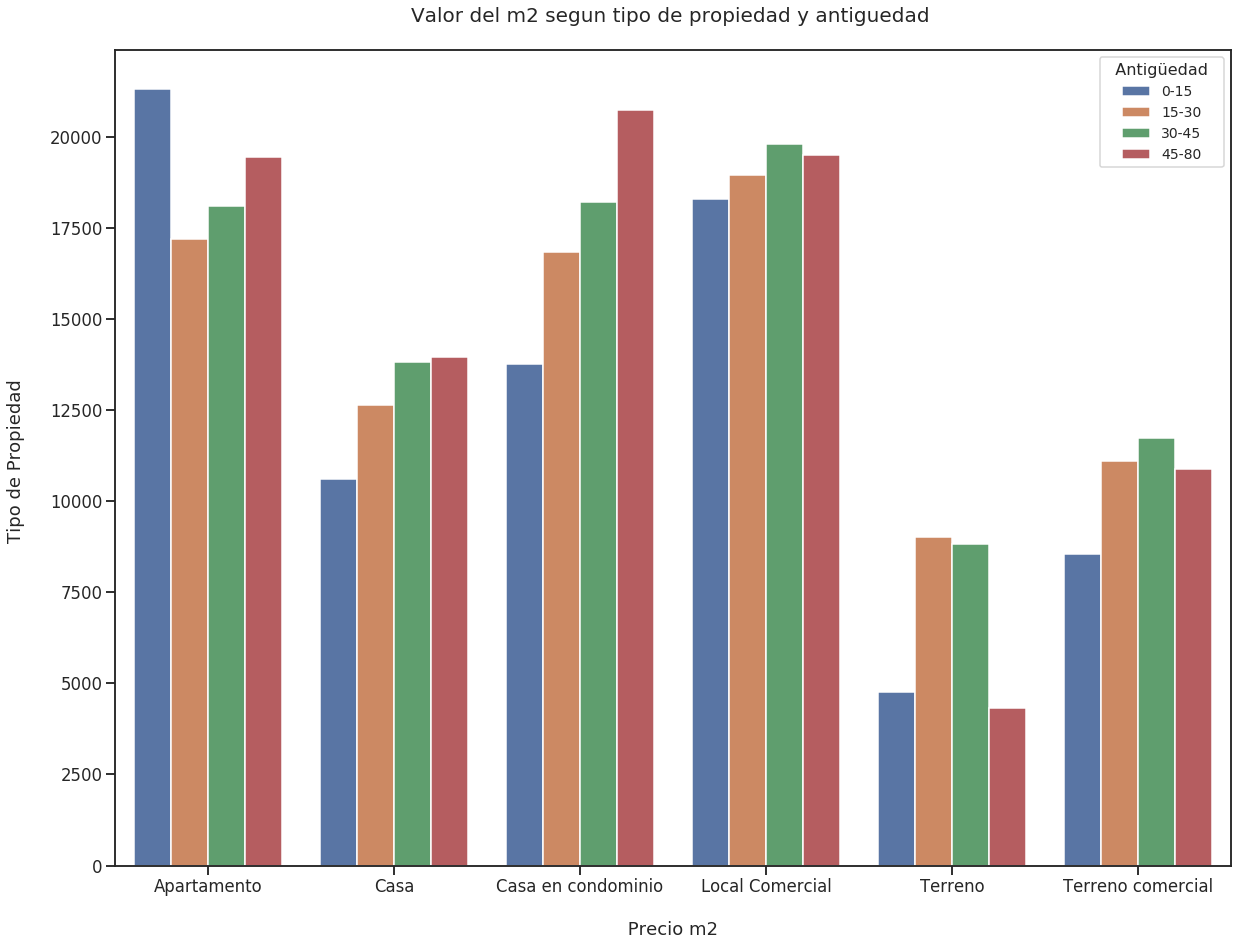

In [146]:
# Se tomn las 10 provincias con mas casas y los 20 tipos de propiedades mas comunes.
# Se evalua el precio del metro cuadrado para cada tipo de propiedad en una provincia distinta

df3 = df.copy()
df3['rango_antiguedad'] = pd.cut(df['antiguedad'],\
                                 bins=[-1,15,30,45,80],\
                                 labels=['0-15', '15-30', '30-45', '45-80'])

plt.figure(figsize=(20,15))
data = df3.groupby(['rango_antiguedad','tipodepropiedad']).agg({'precio_m2':'mean'})
data = data.reset_index()
data.tipodepropiedad.cat.remove_unused_categories(inplace=True)
pivot = data.pivot(index='tipodepropiedad', columns='rango_antiguedad', values='precio_m2')
mask = pivot.isnull()
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
#ax = sns.heatmap(pivot, cmap="YlGnBu")
ax = sns.barplot(data=data, x='tipodepropiedad', y='precio_m2', hue='rango_antiguedad')
ax.set_xlabel('\n Precio m2 ', fontsize=18)
ax.set_ylabel('Tipo de Propiedad \n', fontsize=18)
ax.set_title('Valor del m2 segun tipo de propiedad y antiguedad \n', fontdict={'fontsize':20})
plt.legend(title='  Antigüedad  ', title_fontsize=16, fontsize=14, loc='best')

# De este grafico, se puede sacar como informacion:
# Los tres tipos de casas, tienden a incrementar levemente su valor.
# Los apartamentos, y los edificios, tienden a decrementar levemente su valor.
# El resto presentan un comportamiento irregular, del que es dificil predecir algo.

Text(0, 0.5, 'Cantidad \n')

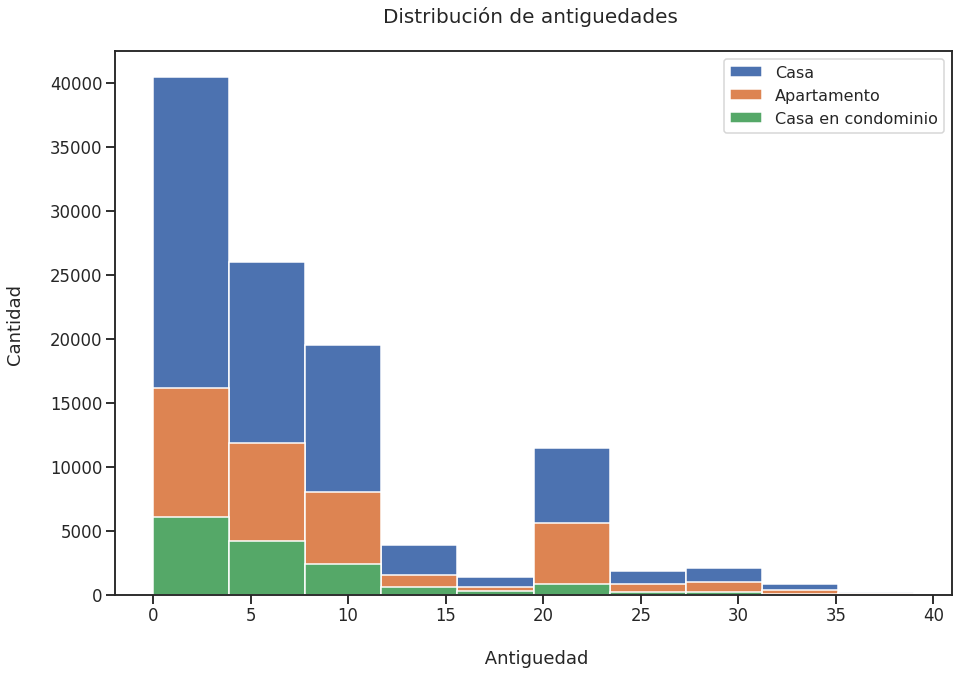

In [97]:
df2 = df.copy()
df2 = df2[df2.antiguedad<40]
df2['antiguedad'] = pd.to_numeric(df2['antiguedad'], errors='coerce')
df2.dropna(subset=['antiguedad'], inplace=True)
df2['antiguedad'] = df2['antiguedad'].astype(int)
plt.figure(figsize=(15,10))
sns.distplot( df2.loc[df2.tipodepropiedad=='Casa'].antiguedad, kde=False, bins=10, hist_kws=dict(alpha=1))
sns.distplot( df2[df2.tipodepropiedad=='Apartamento'].antiguedad, kde=False, bins=10, hist_kws=dict(alpha=1))
sns.distplot( df2.loc[df2.tipodepropiedad=='Casa en condominio'].antiguedad , kde=False, bins=10, hist_kws=dict(alpha=1))
plt.title('Distribución de antiguedades \n', fontsize=20)
plt.legend(['Casa','Apartamento','Casa en condominio'], fontsize=16);
plt.xlabel('\n Antiguedad', fontsize=18)
plt.ylabel('Cantidad \n', fontsize=18)

# Heatmap antiguedad: provincia-tipo de propiedad
# Se puede ver que la mayor concentracion de propiedades se encuenttra entre los 0-5 anos y se puede ver un claro patron
# de que se mantienen las proporciones de cada tipo de propiedad con la antiguedad. Para una mejor visualizacion se propone
# un grafico de densidad.

Text(0, 0.5, 'Porcentaje \n')

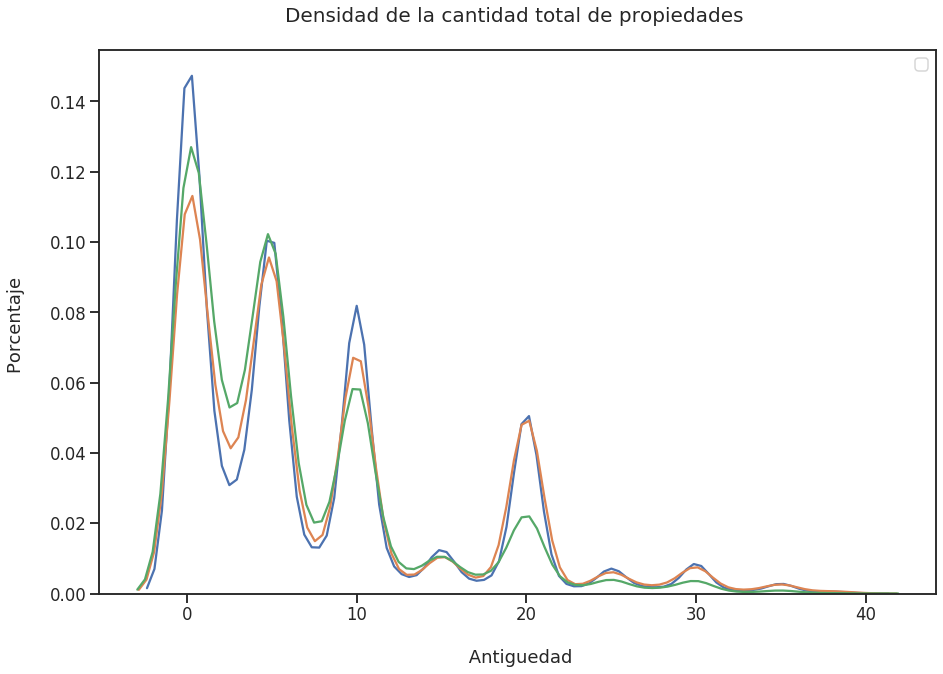

In [99]:
plt.figure(figsize=(15,10))

sns.distplot( df2.loc[df2.tipodepropiedad=='Casa'].antiguedad, hist=False, bins=20, hist_kws=dict(alpha=1))
sns.distplot( df2[df2.tipodepropiedad=='Apartamento'].antiguedad, hist=False, bins=20, hist_kws=dict(alpha=1))
sns.distplot( df2.loc[df2.tipodepropiedad=='Casa en condominio'].antiguedad , hist=False, bins=30, hist_kws=dict(alpha=1))

plt.title('Densidad de la cantidad total de propiedades \n', fontsize=20)
plt.legend(['Casa','Apartamento','Casa en condominio'], loc='best', fontsize=16)
plt.xlabel('\n Antiguedad',fontsize=18)
plt.ylabel('Porcentaje \n')

# Viendo ahora un grafico de densidad correspondiente a la distribucion de cada tipo de propiedad, se puede ver que 
# porcentualmente se confirma lo antes mencionado. (Si la linea azul fuese casas, el 14% de las casas tienen antiguedad 0
# el 10% )
# Se 
# ESto se puede enter: 
# * Considerando que la probabilidad de que alguien haya cargado una propiedad de 5 anos es la misma que la de alguin
#   que cargo una de 10 anos. Se podria tomar este grafico como la evolucion temporal 

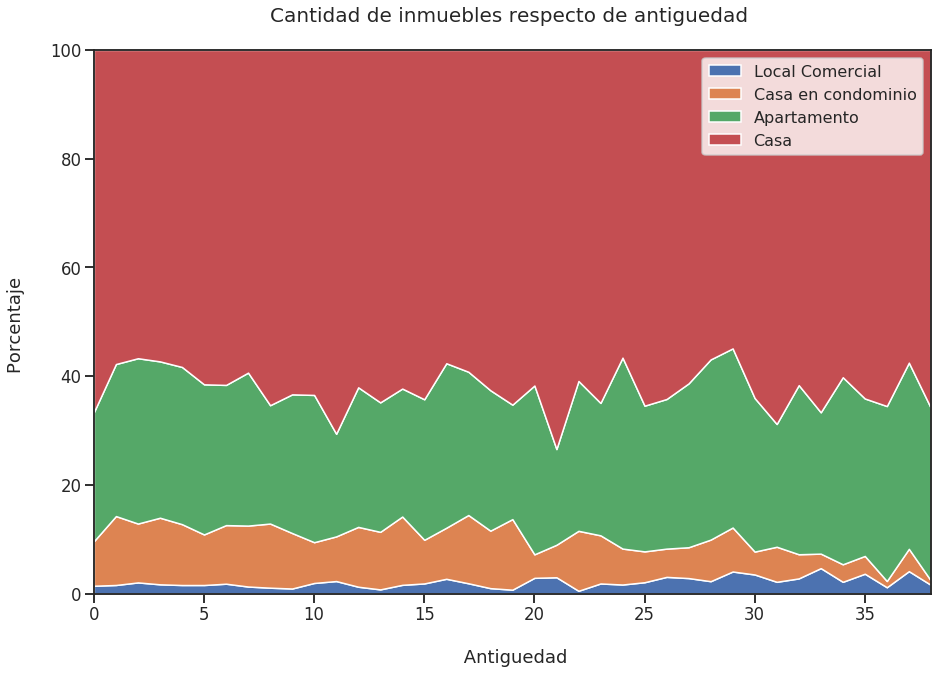

In [103]:
# Grafico de area: Agrupando por antiguedad y tipo de propiedad, me fijo cuanta cantidad de propiedades hay.

plt.figure(figsize=(15,10))

df2 = df.copy()

df2 = df2[df2.tipodepropiedad.isin(['Apartamento','Casa','Casa en condominio','Local Comercial'])]

df2.tipodepropiedad.cat.remove_unused_categories(inplace=True)

df2 = df2.groupby(['tipodepropiedad','antiguedad']).size().to_frame().reset_index().rename(columns={0:'count'})

df2 = df2.loc[df2['antiguedad']<39,:]

pivot = df2.pivot('tipodepropiedad','antiguedad','count')

pivot = pivot.T

total = pivot.sum(axis=1)

pivot['Apartamento'] = pivot['Apartamento']/total *100
pivot['Casa'] = pivot['Casa']/total *100
pivot['Casa en condominio'] = pivot['Casa en condominio']/total *100
pivot['Local Comercial'] = pivot['Local Comercial']/total *100
pivot

ax = plt.stackplot(pivot.index.to_list(),  pivot['Local Comercial'], pivot['Casa en condominio'], pivot['Apartamento'], pivot['Casa'], labels = ['Local Comercial','Casa en condominio','Apartamento','Casa'])
plt.legend(loc='best', fontsize=16)
plt.margins(0,0)
plt.title('Cantidad de inmuebles respecto de antiguedad \n', fontsize=20)
plt.xlabel('\n Antiguedad', fontsize=18)
plt.ylabel('Porcentaje \n', fontsize=18)
plt.show()

In [83]:
# library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
 
# Make data
data = pd.DataFrame({  'group_A':[1,4,6,8,9], 'group_B':[2,24,7,10,12], 'group_C':[2,8,5,10,6], }, index=range(1,6))
 
# We need to transform the data from raw data to percentage (fraction)
data_perc = data.divide(data.sum(axis=1), axis=0)

data_perc

# Make the plot
#plt.stackplot(range(1,6),  data_perc["group_A"],  data_perc["group_B"],  data_perc["group_C"], labels=['A','B','C'])
#plt.legend(loc='upper left')
#plt.margins(0,0)
#plt.title('100 % stacked area chart')
#plt.show()


,group_A,group_B,group_C
1,0.20,0.40,0.40
2,0.11,0.67,0.22
3,0.33,0.39,0.28
4,0.29,0.36,0.36
5,0.33,0.44,0.22


# Analisis por fecha
# ------------------------------------------------------------------------------------------------------------

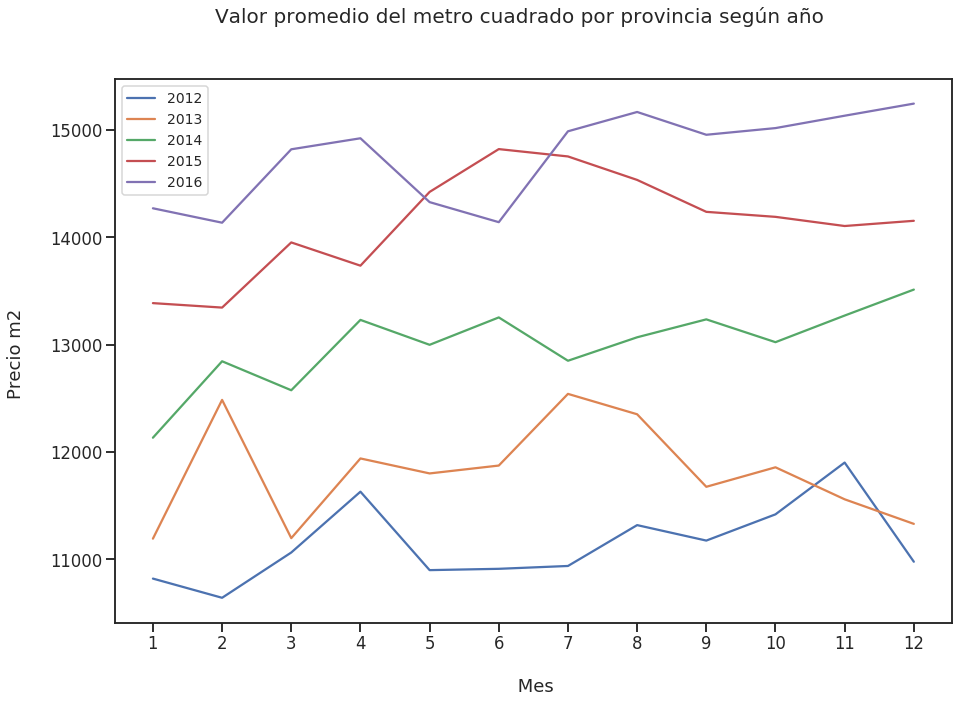

In [84]:
# Como fue variando el precio del metro cuadrado en pesos mexicanos a lo largo de los años?
df2 = df.copy()
df2 = df2.groupby(['año','mes']).agg({'precio_m2':'mean'})
df2 = df2.reset_index()

fig,ax1 = plt.subplots(1,1, figsize=(15,10))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Valor promedio del metro cuadrado por provincia según año',fontsize=20)

for año in [2012,2013,2014,2015,2016]:
    
    ax1.plot(df2[(df2.año==año)].mes,\
            df2[(df2.año==año)].precio_m2,\
            label=año)

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])    
ax1.set_xlabel("\n Mes", fontsize=18)
ax1.set_ylabel("Precio m2 \n", fontsize=18)
ax1.legend(loc='best', title_fontsize=16, fontsize=14)


# De este grafico se observa:
# Este grafico son todos los anteriores juntos.
# Las 5 lineas, respectivas a cada año, son casi paralelas, y salvo 2013 (se mantiene), todas incrementan.
# Esto nos da la pauta de que año a año los valores de las propiedades, van subiendo.

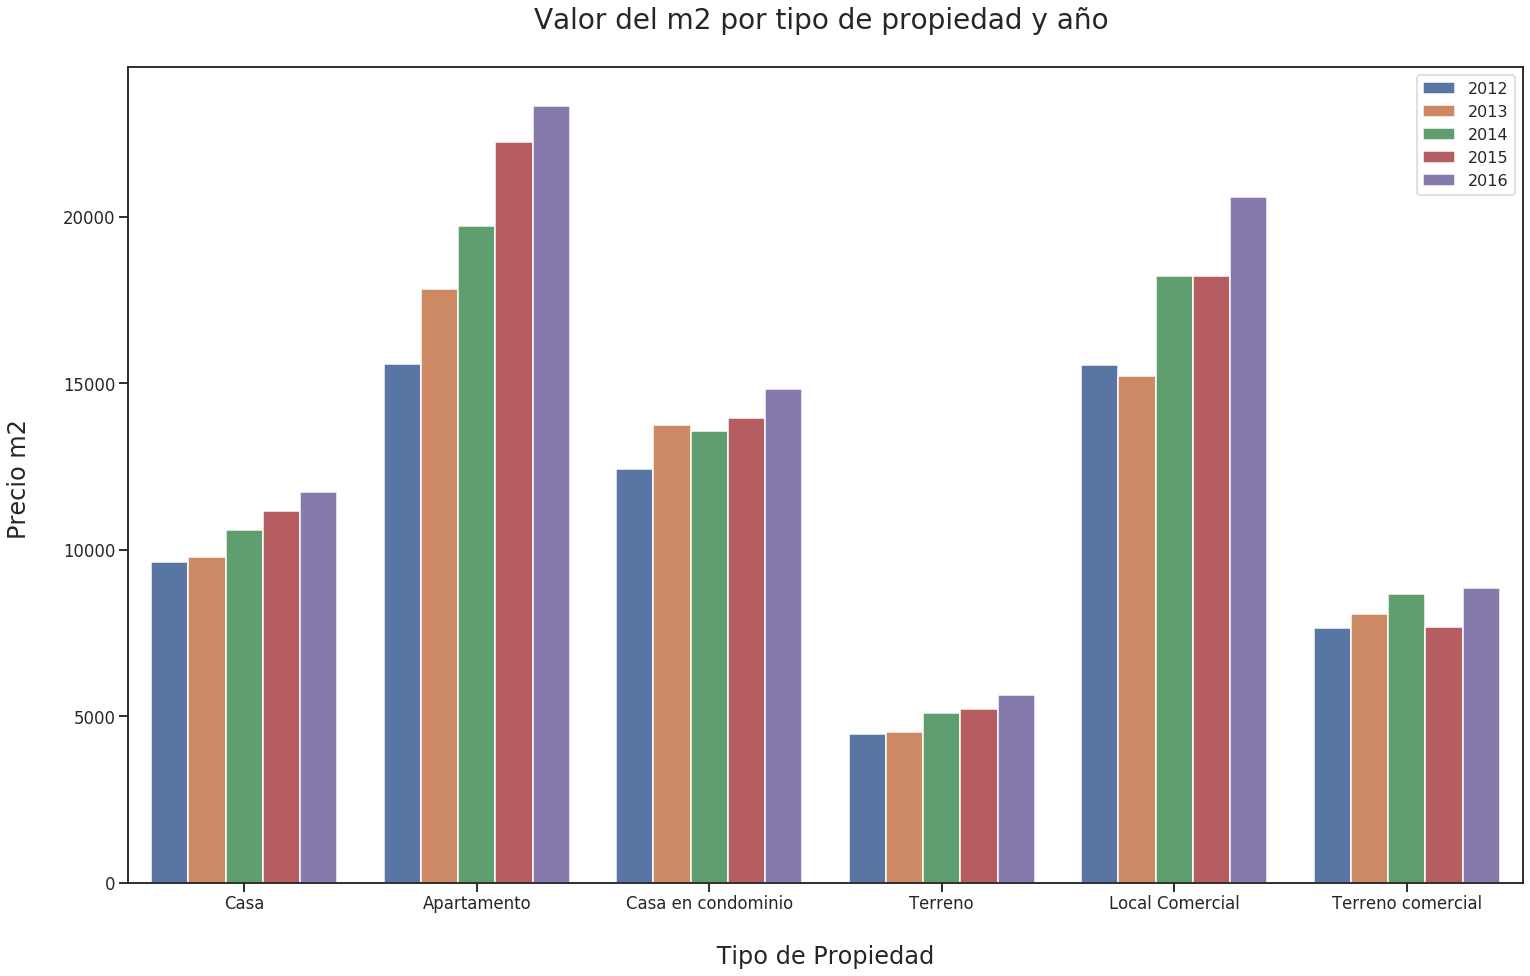

In [85]:
# Y si tomo en cuenta los tipos de propiedades. Todas fueron subiendo de precio? O como se comportaron?
# Filtro para asegurarme de que los grupos que tomo sean de mas de 20 casas

df_años = df.groupby(['año','tipodepropiedad']).filter(lambda x: len(x)>20).groupby(['año','tipodepropiedad']).agg({'precio_m2':'mean'})
top_5_tipos_mas_comunes = df.groupby('tipodepropiedad').size().sort_values(ascending=False)[0:10]
top_5_tipos_mas_comunes = list(top_5_tipos_mas_comunes.index)
plt.figure(figsize=(25, 15))

df_años = df_años.reset_index()

df_años = df_años.loc[df_años['tipodepropiedad'].isin(top_5_tipos_mas_comunes), :]
df_años.tipodepropiedad.cat.remove_unused_categories(inplace=True)

df_años.rename(columns={'tipodepropiedad':'Tipo de propiedad'}, inplace=True)

ax = sns.barplot(data=df_años, x='Tipo de propiedad', y='precio_m2', hue='año', order=top_5_tipos_mas_comunes)

ax.set_xlabel('\n Tipo de Propiedad ', fontsize=24)
ax.set_ylabel('Precio m2 \n', fontsize=24)
ax.set_title('Valor del m2 por tipo de propiedad y año \n', fontdict={'fontsize':28})
ax.legend(loc='best', title_fontsize=18, fontsize=16)
plt.show()

# El grafico muestra, para cada tipo de propiedad y para cada año, como fue variando el precio.
# En todos los casos sube, a excepcion del Terreno Comercial, que, por alguna razon que desconozco, en 2012
# tenia un valor altisimo. Esta anomalía quizas es algo para mirar detenidamente.

# Quizas esto es algo que podriamos ver si, en dolares, tambien subio. Porque puede que sea simplemente por la inflacion
# del peso mexicano


# TODO: ESTO VA MEJOR CON UN GRAFICO DE LINEAS COMO EL DE ARRIBA


# Analisis por ubicación (provincia y ciudades)
# ------------------------------------------------------------------------------------------------------------

In [86]:
top_3_provincias_mas_pobladas = df.groupby('provincia').size().sort_values(ascending=False)[0:3]
top_3_provincias_mas_pobladas = list(top_3_provincias_mas_pobladas.index)
plt.figure(figsize=(20, 10))

df_provincias = df.groupby(['provincia','tipodepropiedad']).agg({'precio_m2':'mean'})

df_provincias = df_provincias.reset_index()
df_provincias

,provincia,tipodepropiedad,precio_m2
0,Aguascalientes,Apartamento,13216.45
1,Aguascalientes,Casa,7588.02
2,Aguascalientes,Casa en condominio,9402.97
3,Aguascalientes,Local Comercial,11587.99
4,Aguascalientes,Terreno,3141.11
...,...,...,...
187,Zacatecas,Casa,7485.05
188,Zacatecas,Casa en condominio,6609.54
189,Zacatecas,Local Comercial,17500.00
190,Zacatecas,Terreno,5508.41


<Figure size 1440x720 with 0 Axes>

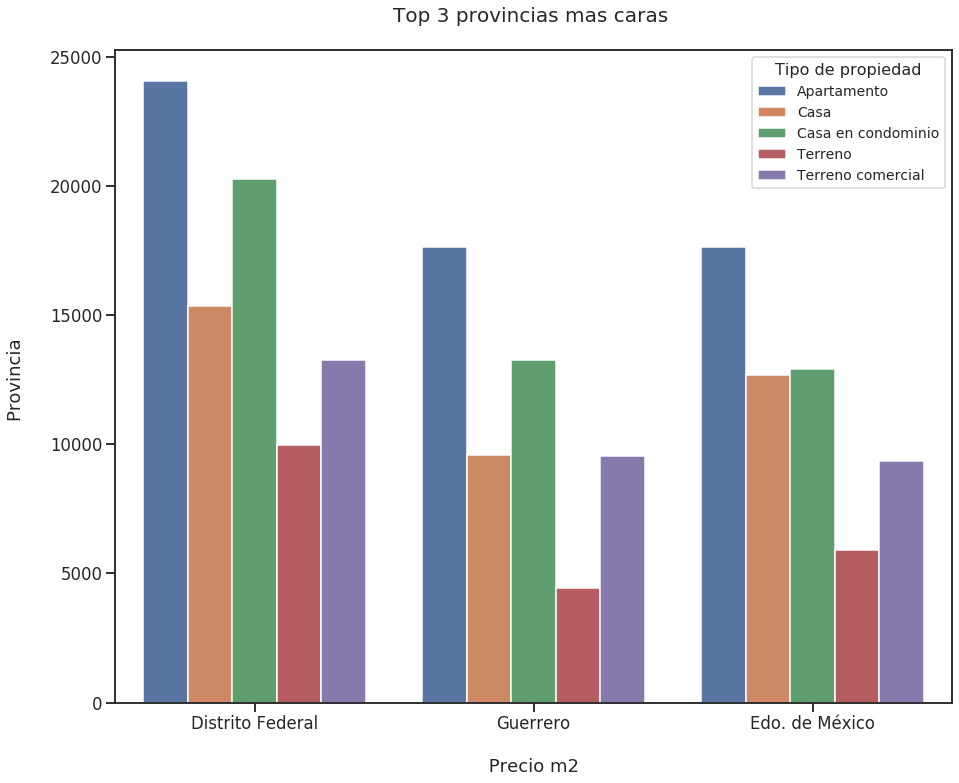

In [87]:
top_3_provincias_mas_caras = df.groupby('provincia').agg({'precio_m2':'mean'}).sort_values(by='precio_m2',ascending=False)[0:3]
top_3_provincias_mas_caras = list(top_3_provincias_mas_caras.index)
plt.figure(figsize=(15, 12))

df_provincias = df.groupby(['provincia','tipodepropiedad']).agg({'precio_m2':'mean'})

df_provincias = df_provincias.reset_index()

df_provincias = df_provincias.loc[df_provincias['tipodepropiedad'].isin(['Apartamento','Casa','Casa en condominio','Terreno','Terreno comercial']), :]
df_provincias.tipodepropiedad.cat.remove_unused_categories(inplace=True)

df_provincias.rename(columns={'tipodepropiedad':'Tipo de propiedad'}, inplace=True)

ax = sns.barplot(data=df_provincias, x='provincia', y='precio_m2', hue='Tipo de propiedad', order=top_3_provincias_mas_caras)

ax.set(xlabel='\n Provincia ', ylabel='Precio m2 \n')
ax.set_title('Top 3 provincias mas caras \n', fontdict={'fontsize':20})
ax.set_xlabel('\n Precio m2 ', fontsize=18)
ax.set_ylabel('Provincia \n', fontsize=18)
plt.legend(title='Tipo de propiedad', title_fontsize=16, fontsize=14)
plt.show()


# Este grafico esta de mas ya qe dice lo mismo que el de abajo. Deberia hacer alguno con las ciudades


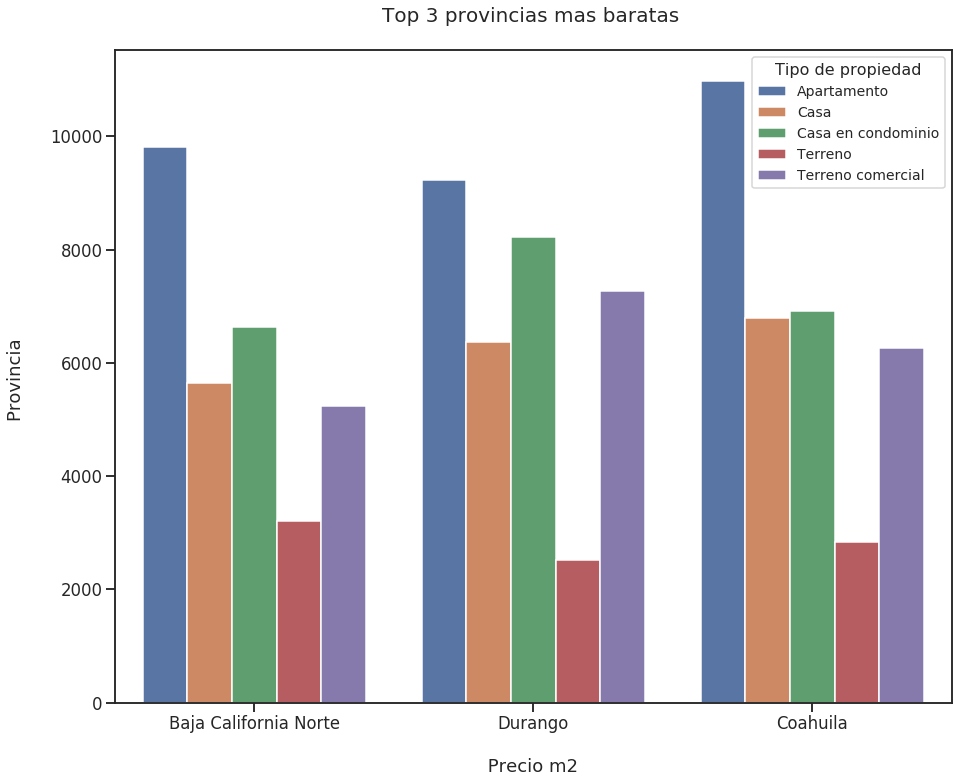

In [88]:
top_3_provincias_mas_baratas = df.groupby('provincia').agg({'precio_m2':'mean'}).sort_values(by='precio_m2',ascending=True)[0:3]
top_3_provincias_mas_baratas = list(top_3_provincias_mas_baratas.index)
plt.figure(figsize=(15, 12))

df_provincias = df.groupby(['provincia','tipodepropiedad']).agg({'precio_m2':'mean'})

df_provincias = df_provincias.reset_index()

df_provincias = df_provincias.loc[df_provincias['tipodepropiedad'].isin(['Apartamento','Casa','Casa en condominio','Terreno','Terreno comercial']), :]
df_provincias.tipodepropiedad.cat.remove_unused_categories(inplace=True)

df_provincias.rename(columns={'tipodepropiedad':'Tipo de propiedad'}, inplace=True)

ax = sns.barplot(data=df_provincias, x='provincia', y='precio_m2', hue='Tipo de propiedad', order=top_3_provincias_mas_baratas)

ax.set(xlabel='\n Provincia ', ylabel='Precio m2 \n')
ax.set_title('Top 3 provincias mas baratas \n', fontdict={'fontsize':20})
ax.set_xlabel('\n Precio m2 ', fontsize=18)
ax.set_ylabel('Provincia \n', fontsize=18)
plt.legend(title='Tipo de propiedad',title_fontsize=16, fontsize=14, loc='upper right')
plt.show()

Text(100.49999999999999, 0.5, '')

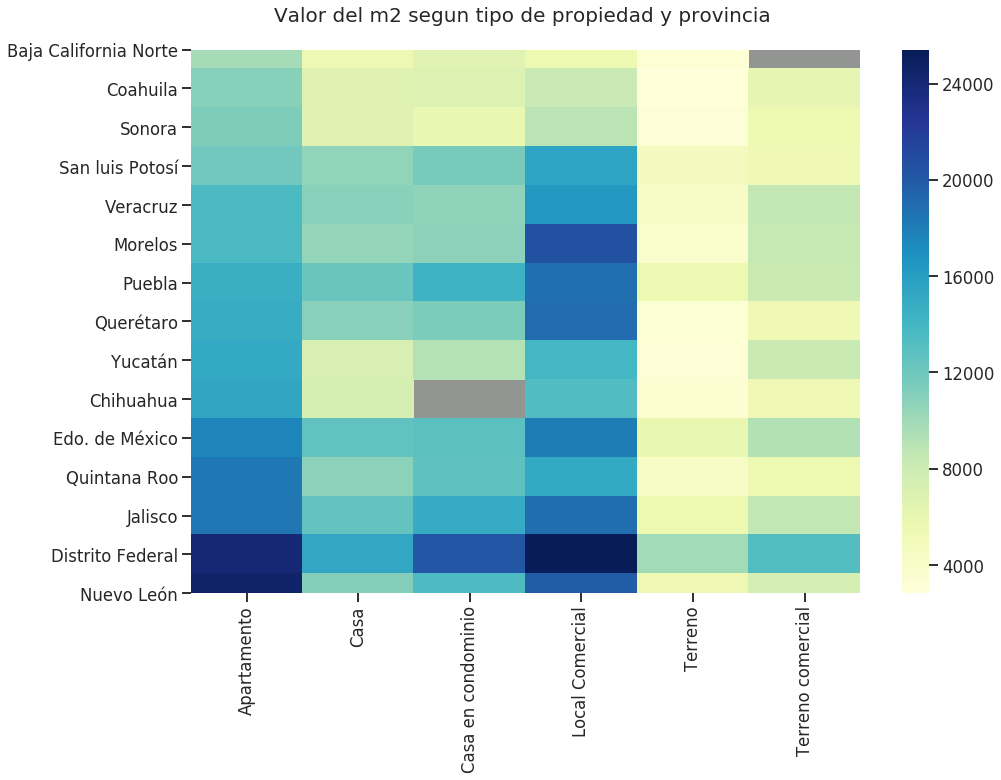

In [89]:
# Se tomn las 15 provincias con mas casas y los tipos de propiedad
# Se evalua el precio del metro cuadrado para cada tipo de propiedad en una provincia distinta

top_10_provincias_mas_pobladas = df.groupby('provincia').size().sort_values(ascending=False)[0:15]
top_10_provincias_mas_pobladas = list(top_10_provincias_mas_pobladas.index)

plt.figure(figsize=(15,10))
data = df.groupby(['provincia','tipodepropiedad']).filter(lambda x: len(x)>10).groupby(['provincia','tipodepropiedad']).agg({'precio_m2':'mean'})
data = data.reset_index()

data = data.loc[data['provincia'].isin(top_10_provincias_mas_pobladas),:]

data.provincia.cat.remove_unused_categories(inplace=True)

pivot = data.pivot(index='tipodepropiedad', columns='provincia', values='precio_m2')

pivot = pivot.T.sort_values(by='Apartamento').T.T

cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
ax = sns.heatmap(pivot, cmap="YlGnBu")
ax.set_facecolor('xkcd:grey')
ax.set_title('Valor del m2 segun tipo de propiedad y provincia \n', fontdict={'fontsize':20})
ax.set_xlabel('')
ax.set_ylabel('')

# Los grises, son missing values

# Este heatmap revela mucha informacion:
# Ranchos, oficinas y locales, son los mas caros
# Los apartamentos, son mas caros que las casas (raro)
# Distrito Federal, es mas caro que el resto
# Ademas, permite ver la variacion del precio segun el lugar y el tipo.
# Dudas. Esta bien dejar los missing values? o deberia sacar esas categorias?
# Podria mostrar mas informacion, pero los missing values crecen considerablemente

/home/ggparente95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


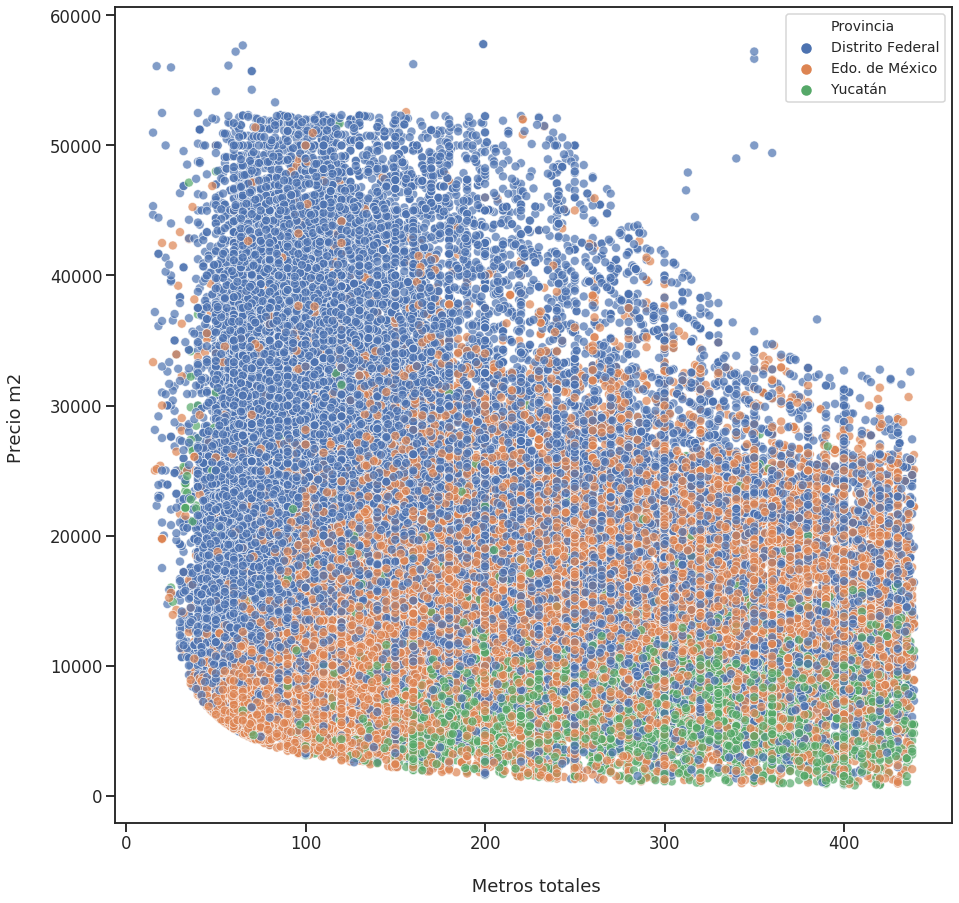

In [90]:
# De lo visto anterior, selecciono tres provincias representativas. Distrito Federal, Coahuila y Yucatán
# Con buen caudal de gente, y con promedios de precios por metro cuadrado distintos.
plt.figure(figsize=(15,15))

data = df[df['provincia'].isin(['Distrito Federal', 'Edo. de México' ,'Yucatán'])]
# Lo hago menro a 90000 ya que, sino, hay algunos datos sueltos que hacne que no se vea tan bien
data = data[df['precio_m2']<=60000]
data.provincia.cat.remove_unused_categories(inplace=True)
data.rename(columns={'provincia':'Provincia'}, inplace=True)

ax = sns.scatterplot(y='precio_m2', x='metrostotales', data=data, hue='Provincia', alpha=0.7)

ax.set_xlabel('\n Metros totales', fontsize=18)
ax.set_ylabel('Precio m2 \n', fontsize=18)
ax.legend(title_fontsize=16, fontsize=14)

# Este scatter plot revela un monton de informacion:
# Primer dato interesante: 
# Las propiedades de mayor valor por metro cuadrado, suelen ser las mas chicas, y las 
# propiedades de menor valor por metro cuadrado, suelen ser las mas grandes.
# Segundo dato curioso: 
# Se puede ver como en Distrito Federal, abundan las propiedades chicas y caras, mientras que en Yucatan hay muchas 
# mas propiedades grandes y con menos valor por metro cuadrado.
# En estado de mexico las casas chicas parecen ser mas baratas que en yucatan y distrito.
# Aca si podria llegar a servir agrupar varias provincias en una para de esa forma poder entender mejor e incluir 
# mucha mas cantidad de datos
